In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
import xgboost
from matplotlib import pylab as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import fbeta_score

In [2]:
df = pd.read_excel(r'C:\Users\ASUS Zephyrus G15\DATA1030-Fall2021\data 1030 project\data\전국상수도수질검사표준데이터.xls')

In [3]:
y = df['Potability']
X = df.loc[:, df.columns != 'Potability']

In [4]:
std_ftrs = ['general_bacteria','lead','fluoride','arsenic','selenium','ammonia-like_nitrogen',
            'nitrogen_nitrate','cadmium','phenol','diazinone','carbaryl','1_1_1-trichloroethane','tetrachloroethylene','trichloroethylene',
            'carbon_tetrachloride','1_1-dichloroethylene','dichloromethane','toluene','Xylene','1_2-dibromo-3-chloropropane','1_4-dioxane.','residual_goat',
            'total_trihalomethane','chloroform','bromodichloromethane','chloral_hydrate','dibromoacetonitrile','dichloroacetonitrile','trichloroacetonitrile',
            'haloacetic_seed','formaldehyde','Bronze','chromaticity','detergent','pH','zinc','chloride_ion','Fe','Mn',
            'turbidity','sulfate_ion','potasium_permanganate_consumption','aluminum']

preprocessor = ColumnTransformer(transformers=[('std', StandardScaler(), std_ftrs)])

param_grid = {"xgbclassifier__max_depth"        : [ 1, 3, 5, 10, 30, 50, 100],
              "xgbclassifier__min_child_weight" : [ 1, 3, 5, 7 ],
              "xgbclassifier__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]
             }
test_scores = np.zeros(5)
final_models = []

for i in range(5):
    X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=47*i)

    # splitter for other
    kf = KFold(n_splits=5,shuffle=True,random_state=47*i)

    # the classifier
    clf = xgboost.XGBClassifier(use_label_encoder=False,n_estimators=100, 
                             learning_rate=0.2,subsample=0.66, nthread=1)# initialize the classifier
    pipe = make_pipeline(preprocessor,clf)

    # use GridSearchCV
    # GridSearchCV loops through all parameter combinations and collects the results 
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
    
    # this line actually fits the model on other
    grid.fit(X_other, y_other)
    # save results into a data frame. feel free to print it and inspect it
    results = pd.DataFrame(grid.cv_results_)
    #print(results)

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    # save the model
    final_models.append(grid)
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test)
    test_scores[i] = accuracy_score(y_test,y_test_pred)
    print('test score:',test_scores[i])
    print('test baseline = ',np.sum(y_test == 0)/len(y_test))
    print('test accuracy:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
    
    fname = r'C:\Users\ASUS Zephyrus G15\DATA1030-Fall2021\data 1030 project\results\XGB'+str(i)+'.lasso'
    file = open(fname, 'wb')
    pickle.dump((grid,X_test,y_test),file)
    file.close()

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[03:17:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best model parameters: {'xgbclassifier__gamma': 0.3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1}
validation score: 0.8679395941481831
test score: 0.8725490196078431
test baseline =  0.42892156862745096
test accuracy: 0.17 +/- 0.35
Fitting 5 folds for each of 140 candidates, totalling 700 fits
[03:17:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior

In [5]:
y_true = y_test
y_preds = y_preds = grid.predict(X_test)
                                         
print(confusion_matrix(y_true,y_preds))

[[130  25]
 [ 24 229]]


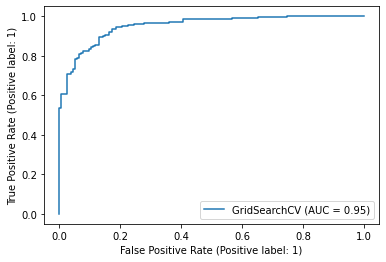

In [6]:
roc = plot_roc_curve(grid, X_test, y_test);

In [7]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

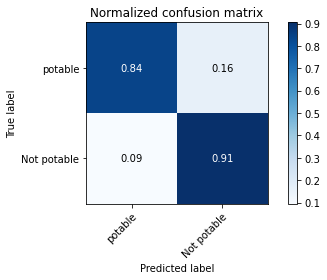

In [8]:
plot_confusion_matrix(y_true,y_preds,classes=['potable','Not potable'])
plt.tight_layout()
plt.savefig(r'C:\Users\ASUS Zephyrus G15\DATA1030-Fall2021\data 1030 project\figures\XGB_Confusion_matrix',dpi = 300)
plt.show()

In [9]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       155
           1       0.90      0.91      0.90       253

    accuracy                           0.88       408
   macro avg       0.87      0.87      0.87       408
weighted avg       0.88      0.88      0.88       408



In [4]:
from luciferml.supervised.classification import Classification
from luciferml.preprocessing import Preprocess as prep

In [5]:
accuracy_scores = {}


          
██╗░░░░░██╗░░░██╗░█████╗░██╗███████╗███████╗██████╗░░░░░░░███╗░░░███╗██╗░░░░░
██║░░░░░██║░░░██║██╔══██╗██║██╔════╝██╔════╝██╔══██╗░░░░░░████╗░████║██║░░░░░
██║░░░░░██║░░░██║██║░░╚═╝██║█████╗░░█████╗░░██████╔╝█████╗██╔████╔██║██║░░░░░
██║░░░░░██║░░░██║██║░░██╗██║██╔══╝░░██╔══╝░░██╔══██╗╚════╝██║╚██╔╝██║██║░░░░░
███████╗╚██████╔╝╚█████╔╝██║██║░░░░░███████╗██║░░██║░░░░░░██║░╚═╝░██║███████╗
╚══════╝░╚═════╝░░╚════╝░╚═╝╚═╝░░░░░╚══════╝╚═╝░░╚═╝░░░░░░╚═╝░░░░░╚═╝╚══════╝

Started LuciferML 

Checking if labels or features are categorical! [*]

Features are not categorical [ ✓ ]

Labels are not categorical [ ✓ ]

Checking for Categorical Variables Done [ ✓ ]

Checking for Sparse Matrix [*]

Checking for Sparse Matrix Done [ ✓ ]

Applying SMOTE [*]

SMOTE Done [ ✓ ]

Splitting Data into Train and Validation Sets [*]

Splitting Done [ ✓ ]

Scaling Training and Test Sets [*]

Scaling Done [ ✓ ]

Training XGBClassifier on Training Set [*]



C:\Anaconda\envs\data1030\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Model Training Done [ ✓ ]

Predicting Data [*]

Data Prediction Done [ ✓ ]

Making Confusion Matrix [*]


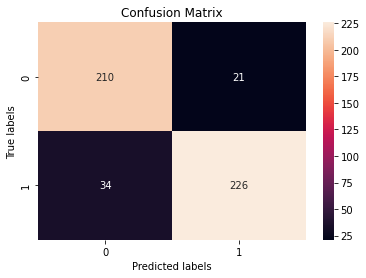

Confusion Matrix Done [ ✓ ]

Evaluating Model Performance [*]
Validation Accuracy is : 0.8879837067209776
Evaluating Model Performance [ ✓ ]

Applying K-Fold Cross Validation [*]


C:\Anaconda\envs\data1030\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\envs\data1030\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Anaconda\envs\data1030\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use 

Accuracy: 90.92 %
Standard Deviation: 2.29 %
K-Fold Cross Validation [ ✓ ]

Complete [ ✓ ]

Time Elapsed :  8.934941053390503 seconds 



In [6]:
params = {'learning_rate':0.02, 'n_estimators':600, 'objective':'binary:logistic', 'eval_metric':'logloss', 'nthread':-1}
classifier =  Classification(predictor = 'xgb',params=params, smote = 'y')
classifier.fit(X, y)
result = classifier.result()
accuracy_scores[result['Classifier']] = result['Accuracy']

In [9]:
accuracy_scores

{}

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [68]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.67162
[100]	test-logloss:0.49150
[200]	test-logloss:0.41875
[300]	test-logloss:0.38113
[400]	test-logloss:0.35466
[500]	test-logloss:0.33893
[600]	test-logloss:0.32739
[700]	test-logloss:0.31857
[800]	test-logloss:0.31324
[900]	test-logloss:0.30874
[1000]	test-logloss:0.30511
[1084]	test-logloss:0.30394


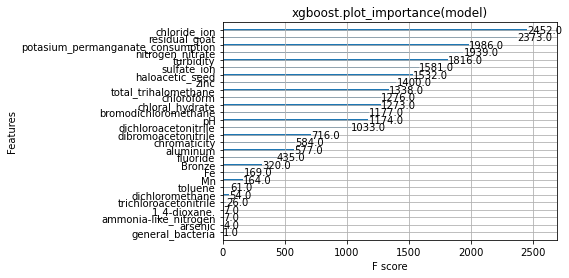

In [69]:
xgboost.plot_importance(model)
plt.title("xgboost.plot_importance(model)")
plt.show()

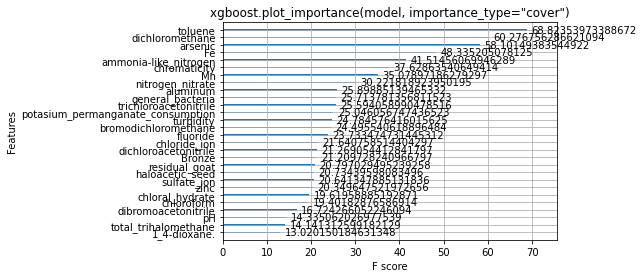

In [70]:
xgboost.plot_importance(model, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

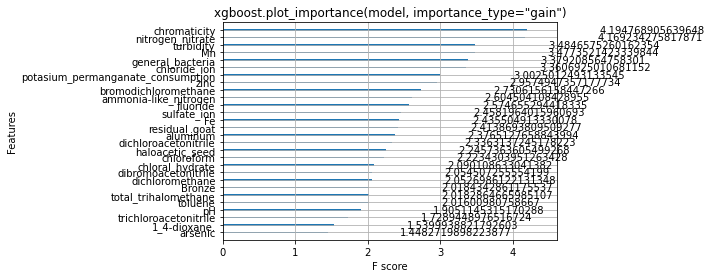

In [71]:
xgboost.plot_importance(model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()